# Compare Models

In [1]:
import sys
sys.path.append("../")

from haxml.utils import (
    get_stadiums,
    get_matches_metadata,
    train_test_split_matches_even_count,
    get_opposing_goalpost,
    stadium_distance,
    angle_from_goal,
    is_scored_goal,
    get_positions_in_range,
    get_positions_at_time,
    #Edwins
    defender_feature, # closest defender, defenders within dist
    defender_box, # count defender within goal and shot in rect
    defender_cone, # count defenders between shot and goal in cone
    speed_ball
)
from haxml.evaluation import (
    summarize_split,
    style_columns,
    make_df,
    score_model,
    run_models,
    blank_plot,
    plot_errors_by_kicks,
    plot_errors_by_goals,
    plot_xg_histogram
)
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## Load Data and Make Train/Test Split

In [2]:
stadiums = get_stadiums("../data/stadiums.json")
metadata = get_matches_metadata("../data/matches_metadata.csv")
train, test = train_test_split_matches_even_count(metadata)

In [3]:
print("Train Data:")
summarize_split(train)
print()
print("Test Data:")
summarize_split(test)

Train Data:
Matches: 929
Goals: 2,441
Kicks: 97,380
E(XG): 0.025

Test Data:
Matches: 928
Goals: 2,437
Kicks: 95,124
E(XG): 0.026


## Feature Engineering

Add all your new features to the `generate_rows_compare()` method.

In [4]:
dict = {}
if dict:
    print('yay')
else:
    print('no')

no


In [5]:
def shot_intersection(match,kick, stadium, frame):
    '''Finds where the ball would intersect
    Args:
    match: Which match it is
    kick: Which kick we want to measure
    staduim: What stadium size it is (so we know where the goals and bounds are)

    Returns:
    Int 1 or 0 if the ball is going towars the goal or not
    '''
    #Getting last frame before the kick 
    #print("Calculate intersection at time: {}".format(kick["time"] - offset))
    #frame = get_positions_at_time(match["positions"], kick["time"] - offset)
    #Using in range and tracing back to see what frame was right before it left the foot
    #A list of lists with only info about player we want and ball
    shooter_frames = []
    ball_frames = []
    #print(kick['fromName'])
    for i in frame:
        if i['name'] == kick['fromName']: 
            shooter_frames.append(i)  
        elif i['type'] == 'ball':
            ball_frames.append(i)
    #print(shooter_frames)
    #print(ball_frames)
    #picking frame with least dist
    least_dist = float('inf')
    player_position = {}
    ball_position = {}
    #List of dicts
    length = min(len(shooter_frames),len(ball_frames))
    set_dist = 30 #ball and player are at least get within 30 units then we assume that it was kicked
    
    for i in range(length-1,-1,-1): #frame len of ball and shooter should be the same
        dist = stadium_distance(shooter_frames[i]['x'],shooter_frames[i]['y'],ball_frames[i]['x'],ball_frames[i]['y'])
        if dist <= set_dist:
            player_position = shooter_frames[i]
            ball_position = ball_frames[i]
            break
    #If a frame isn't found with dist that is <= 30, then use least dist to calculate
    if not (ball_position) or not (player_position): #The dictionaries were not populated yet so default to getting least distance
        for i in range(length-1,-1,-1): #frame len of ball and shooter should be the same
            dist = stadium_distance(shooter_frames[i]['x'],shooter_frames[i]['y'],ball_frames[i]['x'],ball_frames[i]['y'])
            if dist <= least_dist:
                player_position = shooter_frames[i]
                ball_position = ball_frames[i]
                least_dist = dist
            else: #stopped decreasing
                break
    #print(frame)
    #print(player_position)
    #print(ball_position)
    #Getting goal positions
    goal_mid = get_opposing_goalpost(stadium, kick['fromTeam'])['mid']
    #print(goal_mid)
     #Extend line from shot angle (can't extend lines easily)
    if(len(player_position)==0 or len(ball_position)==0):
        return None, None, None
    y_val = point_slope(
        player_position,
        slope(player_position['x'], player_position['y'], ball_position['x'], ball_position['y']),
        goal_mid['x']
    )
    #Checking if the projection between the posts
    intersect = { 'x': goal_mid['x'], 'y': y_val }
    return player_position, ball_position, intersect

In [6]:
def is_bounce (match,kick, stadium):
    '''Figuring out if shot bounces off the sidelines
    Args:
        match: Which match it is
        kick: Which kick we want to measure
        stadium: Which staduim was it played on

    Returns:
            1 if shot bounces and 0 if it isn't
'''
    #Get parameters for the sidelines and it intersects the side line then set to 1 if not, the set is_bounce to 0
    if True:
        return 1
    else:
        return 0

In [7]:
def point_slope(p, slope,x_goal):
    #y - y1 = m(x-x1) -->  y=mx-mx1+y1 (returning the y)
    y_val = (slope*x_goal)-(slope*p['x'])+p['y'] 
    return y_val

In [8]:
def slope(x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1+1e-10)
    return m

In [9]:
def shot_on_goal(match, kick, intersect, stadium):
    '''Figuring out if shot is going into the goal or not
        Args:
            match: Which match it is
            kick: Which kick we want to measure
            intersect: x,y of the shot intersection
            stadium: Which staduim was it played on

        Returns:
                1 if shot is on goal, .5 if it hits the post, and 0 if it isn't on goal
    '''
    goal_posts = get_opposing_goalpost(stadium, kick['fromTeam'])['posts']
    if intersect['y'] > goal_posts[0]['y'] and intersect['y'] < goal_posts[1]['y']:
        return 1
    #elif intersect['y'] == goal_posts[0]['y'] or intersect['y'] == goal_posts[1]['y']:
        #hits posts
        #return .5
    else:
        return 0

In [10]:
def speed_player(match,kick,player_name,positions):
    '''' Speed of the player
       Args:
           match: Which match it is
           kick: Which kick we want to measure
           player_name: What player do we want to measure the speed for

        Returns:
           Int that represents the speed of the player
    '''
    #Getting time range to be able to measure distance
    #start = get_positions_at_time(match["positions"], kick["time"] - offset)
    #end = get_positions_at_time(match["positions"], kick["time"])
    #getting positions
    
    #print(positions)
    player_pos = []
    for i in positions:
        if i['name'] == player_name: 
            player_pos.append(i)    
    #print(player_pos)
    #Getting the time
    if len(player_pos) > 1:
        last = len(player_pos)-1#getting last index)
        time = player_pos[last]['time'] -  player_pos[0]['time'] 
        #Getting the distance 
        distance = stadium_distance(player_pos[0]['x'],player_pos[0]['y'],player_pos[last]['x'],player_pos[last]['y'])
        #dist_formula(player_pos[0]['x'],player_pos[0]['y'],player_pos[last]['x'],player_pos[last]['y'])
        #print("dist:" + str(distance))
        #print("time:" + str(time))
        #Returns speed
        #NEED TO CHANGE TIME INTO SECONDS SO THAT IT IS CONSTANT AND NOT DIVIDING BY DIFF VALS
        return distance/time
    else:
        return 0

In [11]:
def defender_feature_weighted(match,kick,stadium,positions,dist=0):
    '''Figuring out the closest defender and num of defenders for a kick
        Note: This is weighted so that defenders that are close to the player/ball or the goal count as 1.5 rather than 1
        Args:
            match: Which match it is
            kick: Which kick we want to measure
            dist: Set distance to consider a player pressuring

        Returns:
                List that contains the distance of the closest defender and the number of defenders (weighted)
'''
    closest_defender = float('inf')
    defenders_pressuring = 0
    ret = [0,0]
    for person in positions:
        if person['team'] is not kick['fromTeam'] and person['type'] == "player": 
            defender_dist = stadium_distance(kick['fromX'],kick['fromY'],person['x'],person['y'])
            #((kick['fromX'] - person['x'])**2 + (kick['fromY'] - person['y'])**2)**(1/2)
            if defender_dist < closest_defender:
                closest_defender = defender_dist
                ret[0] = closest_defender
            if defender_dist <= dist:
                #Checking distances  for weights
                post = get_opposing_goalpost(stadium, kick['fromTeam'])
                goal_dist = stadium_distance(post['mid']['x'], post['mid']['y'] ,person['x'],person['y'])
                if defender_dist <= 5:
                    defenders_pressuring += 1.5
                elif goal_dist <= 5:
                    defenders_pressuring += 1.5
                else:
                    defenders_pressuring += 1
                ret[1] = defenders_pressuring
    return ret

In [12]:
def in_stadium(stadium):
    recognized_stadiums = ["NAFL Official Map v1","Futsal 3x3 4x4 from HaxMaps", "Futsalx3 | TK&ED", "Futsal x3 by Bazinga from HaxMaps", "FUTHAX 4v4", "Happy Futsal 3x3 4x4","Happy Futsal 3x3 4x4"]
    if stadium in recognized_stadiums:
        return 1
    return 0

In [13]:
#LABEL BINARIZER FO RTHE STADIUM 
'''from sklearn.preprocessing import LabelBinarizer
recognized_stadiums = ["NAFL Official Map v1","NAFL 1v1/2v2 Map v1",  ]
stadium_binarizer = LabelBinarizer()
stadium_binarizer.fit(recognized_stadiums)
# for each match
binarized = stadium_binarizer.transform(match["stadium"])
for stadium_name, value in zip(stadium_binarizer.classes_, binarized):
    row[stadium_name] = value
# TODO: Add some more logic to correctly assign the value for the other feature
# If none of the values from binarized were 1, set the value to 1, otherwise 0
row["other_stadium"] = 1
'''

'from sklearn.preprocessing import LabelBinarizer\nrecognized_stadiums = ["NAFL Official Map v1","NAFL 1v1/2v2 Map v1",  ]\nstadium_binarizer = LabelBinarizer()\nstadium_binarizer.fit(recognized_stadiums)\n# for each match\nbinarized = stadium_binarizer.transform(match["stadium"])\nfor stadium_name, value in zip(stadium_binarizer.classes_, binarized):\n    row[stadium_name] = value\n# TODO: Add some more logic to correctly assign the value for the other feature\n# If none of the values from binarized were 1, set the value to 1, otherwise 0\nrow["other_stadium"] = 1\n'

In [14]:
def generate_rows_compare(match, stadium):
    """
    Generates target and features for each kick in the match.
    Produces many features for model comparison.
    Args:
        match: Inflated match data (dict).
        stadium: Stadium data (dict).
    Returns:
        Generator of dicts with values for each kick in the given match.
        Includes prediction target "ag" (actual goals) which is 1 for a scored
        goal (goal or error) and 0 otherwise, "index" which is the index of the
        kick in the match kick list, and all the other features needed for
        prediction and explanation.
    """
    for i, kick in enumerate(match["kicks"]):
        gp = get_opposing_goalpost(stadium, kick["fromTeam"])
        x = kick["fromX"]
        y = kick["fromY"]
        gx = gp["mid"]["x"]
        gy = gp["mid"]["y"]
        dist = stadium_distance(x, y, gx, gy)
        angle = angle_from_goal(x, y, gx, gy)
        offset_int = 4
        offset_speed = 1
        end_time = kick["time"]
        pos_int = get_positions_in_range(match["positions"], end_time - offset_int, end_time)
        pos_speed = get_positions_in_range(pos_int, end_time - offset_speed, end_time)
        pos_def = get_positions_at_time(pos_speed, end_time)
        
        player_pos, ball_pos, intersect = shot_intersection(match,kick,stadium, pos_int)
        if intersect is None:
            on_goal = 0
        else:
            on_goal = shot_on_goal(match, kick, intersect, stadium)
        
        name = kick['fromName']
        player_speed = speed_player(match,kick, name, pos_speed)
        
        weighted_def_dist,closest_def = defender_feature_weighted(match,kick,stadium,pos_def,dist=4)
        
        defender_dist,closest_defender = defender_feature(match,kick,100)
        defenders_within_box,in_box = defender_box(match,stadium,kick)
        defenders_within_shot,in_shot = defender_cone(match,stadium,kick,1)
        ball_speed=speed_ball(match,kick,1)
        
        row = {
            "ag": 1 if is_scored_goal(kick) else 0,
            "index": i,
            "time": kick["time"],
            "x": x,
            "y": y,
            "goal_x": gx,
            "goal_y": gy,
            "goal_distance": dist,
            "goal_angle": angle,
            "team": kick["fromTeam"],
            "stadium": match["stadium"],
            #Edwins
            "defender_dist": defender_dist, 
            "closest_defender": closest_defender,
            "defenders_within_box": defenders_within_box, 
            "in_box": in_box, 
            "defenders_within_shot": defenders_within_shot, 
            "in_shot": in_shot, 
            "ball_speed": ball_speed,
            #Lynns
            "on_goal": on_goal,
            "player_speed": player_speed,
            "weighted_def_dist": weighted_def_dist,
            "closest_def": closest_def,
            "in_stadium": match["stadium"]
        }
        
        yield row

In [15]:
d_train = make_df(train, stadiums, generate_rows_compare, progress=True)
d_test = make_df(test, stadiums, generate_rows_compare, progress=True)

100%|██████████| 928/928 [06:49<00:00,  2.27it/s]


## Train Models

Specific all the models and feature sets you want to use below.

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
#New models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

In [17]:
import itertools
all_features = ["goal_angle","goal_distance","defender_dist","closest_defender","in_box","defenders_within_shot",
            "in_shot","ball_speed","on_goal","player_speed","weighted_def_dist","closest_def"]
feature_sets = [
    #Best model results so far
    #["goal_angle","goal_distance","in_shot","ball_speed","on_goal","player_speed", "closest_def"],
    #["goal_angle","goal_distance","in_shot","ball_speed","on_goal","player_speed", "in_box"],
    #["goal_angle","goal_distance","in_shot","ball_speed","on_goal","player_speed", "in_box", "defender_dist"],
    ["goal_angle","goal_distance","defender_dist","closest_defender","in_box","defenders_within_shot","in_shot","ball_speed", "on_goal","player_speed","weighted_def_dist"],
    #["goal_angle","goal_distance","closest_defender","in_box","defenders_within_shot","in_shot","ball_speed", "on_goal","player_speed","weighted_def_dist"],
    ["goal_angle","goal_distance","defender_dist","closest_defender","in_box","defenders_within_shot","in_shot","ball_speed", "on_goal","player_speed"],
    ["goal_angle","goal_distance","closest_defender","in_box","defenders_within_shot","in_shot","ball_speed", "on_goal","player_speed","weighted_def_dist"]
    
    #Others
    #["goal_angle","goal_distance","in_shot","ball_speed","on_goal","player_speed", "weighted_def_dist"],
    #["goal_angle","goal_distance","in_shot","ball_speed","player_speed","in_box"],
    #["goal_angle","goal_distance","on_goal","player_speed"],
    #["goal_angle","goal_distance","on_goal","player_speed"],
    #["goal_angle","goal_distance","in_shot","ball_speed","on_goal","player_speed"],
    #["goal_angle","goal_distance","in_shot","ball_speed","player_speed"],
    #["goal_angle","goal_distance","in_shot","ball_speed","player_speed","in_box", "defender_dist"],
    #["goal_angle","goal_distance","player_speed"],
    #["goal_angle","goal_distance","defender_dist","closest_defender","in_box","defenders_within_shot","in_shot","ball_speed", "on_goal","player_speed"],
    
    #Edwins best
    #["goal_angle","goal_distance","defender_dist","closest_defender","in_box","defenders_within_shot","in_shot","ball_speed"]
   
]
'''
for L in range(0, len(all_features)+1):
    for subset in itertools.combinations(all_features, L):
        if len(subset) != 0:
            feature_sets.append(list(subset))
'''
model_params = [
    #(LogisticRegression, {"random_state": 0}),
    #(LogisticRegression, {"random_state": 0, "penalty":'l1', "solver":'liblinear'}), #added solver b/c lbfgs supports only 'l2' or 'none'
    #(LogisticRegression, {"random_state": 0, "penalty":'none'}),
    
    #(DecisionTreeClassifier, {"max_depth": 3}),
    #(DecisionTreeClassifier, {"max_depth": 5}),
    #(KNeighborsClassifier, {"n_neighbors": 10}),
    (RandomForestClassifier, {"max_depth":15, "random_state":0}),
    
    #(RandomForestClassifier, {"max_depth":8, "random_state":0}),
    #(GaussianNB, {"priors":None}), Bad!!
    #(AdaBoostClassifier, {"n_estimators":50, "random_state":0}), #Not very good either
]

In [18]:
df_scored = run_models(d_train, d_test, score_model, "ag", feature_sets, model_params)

Model: RandomForestClassifier(max_depth=15, random_state=0): 100%|██████████| 3/3 [00:50<00:00, 16.95s/it]


## Rank Models By Score

Call `help()` on `score_model()` to find out what the scoring metrics mean.

In [19]:
help(score_model)

Help on function score_model in module haxml.evaluation:

score_model(d_test, target, features, clf, kwargs)
    Score a given model and return its metrics and metadata.
    Args:
        d_test: DataFrame of test data.
        target: Variable to predict (str).
        features: Columns of DataFrame to use as predictors (list of str).
        clf: Classifier (sklearn style).
        kwargs: Keyword args for classifier.
    Scores:
        accuracy: correct predictions / all records
        precision: true positives / predicted positives
        recall: true positives / actual positives
        roc_auc: area under the ROC curve (0.5 is as good as random)
        match_mae: mean absolute error between XG and AG per match
        match_rmse: root mean squared error between XG and AG per match
        xg_mean: mean of XG on dataset
        xg_std: standard deviation of XG on dataset
    Returns:
        Dictionary with fields for scoring metrics and model metadata.



In [20]:
score_color = "94, 156, 255"
style_config = {
    "accuracy": {"rgb": score_color, "low": 0, "high": 1},
    "precision": {"rgb": score_color, "low": 0, "high": 1},
    "recall": {"rgb": score_color, "low": 0, "high": 1},
    "roc_auc": {"rgb": score_color, "low": 0.5, "high": 1},
    "match_mae": {"rgb": score_color, "low": 3, "high": 0},
    "match_rmse": {"rgb": score_color, "low": 3, "high": 0},
    "xg_mean": {"rgb": score_color, "low": 0, "high": 0.07},
    "xg_std": {"rgb": score_color, "low": 0, "high": 0.5},
}

In [21]:
df_ranked = df_scored \
    .sort_values(by=["recall","precision"], ascending=[False, False]) \
    .reset_index()
df_ranked \
    [["clf", "features"] + list(style_config.keys())] \
    .style.apply(style_columns(style_config)) \
    .set_precision(3)

,clf,features,accuracy,precision,recall,roc_auc,match_mae,match_rmse,xg_mean,xg_std
0,"RandomForestClassifier(max_depth=15, random_state=0)","['goal_angle', 'goal_distance', 'closest_defender', 'in_box', 'defenders_within_shot', 'in_shot', 'ball_speed', 'on_goal', 'player_speed', 'weighted_def_dist']",0.98,0.745,0.32,0.658,1.16,1.45,0.0251,0.0916
1,"RandomForestClassifier(max_depth=15, random_state=0)","['goal_angle', 'goal_distance', 'defender_dist', 'closest_defender', 'in_box', 'defenders_within_shot', 'in_shot', 'ball_speed', 'on_goal', 'player_speed']",0.98,0.739,0.315,0.656,1.17,1.45,0.0251,0.0918
2,"RandomForestClassifier(max_depth=15, random_state=0)","['goal_angle', 'goal_distance', 'defender_dist', 'closest_defender', 'in_box', 'defenders_within_shot', 'in_shot', 'ball_speed', 'on_goal', 'player_speed', 'weighted_def_dist']",0.98,0.767,0.292,0.645,1.17,1.45,0.0249,0.0887


## Save Models


In [22]:
models = df_ranked.to_dict(orient="records")

In [23]:
import joblib
clf = models[0]['clf']
joblib.dump(clf,"../models/lynn_random_forest_max_depth_15_only_weighted_dist.pkl")
clf = models[2]['clf']
joblib.dump(clf,"../models/lynn_random_forest_max_depth_15_both_def_dist.pkl")

['../models/lynn_random_forest_max_depth_15_both_def_dist.pkl']

## Visualize Model Results

Model IDs are the ranks (starting from 0) of the models. We can compare the top three models with these plots.

In [86]:
model_ids = [0, 3, 4]
pal = sns.hls_palette(len(model_ids))

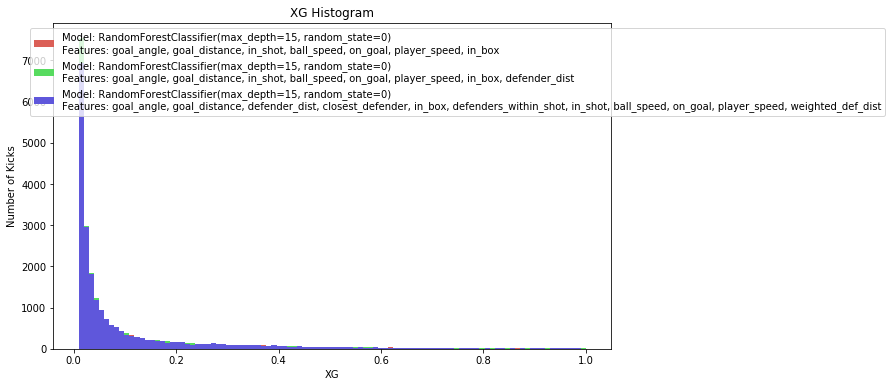

In [61]:
plot = blank_plot()
hist_kwargs = {"bins": 100}
for model_id, color in zip(model_ids, pal):
    hist_kwargs["color"] = color
    plot = plot_xg_histogram(models[model_id], d_test, plot, hist_kwargs, min_xg=1e-2)
plot[0]

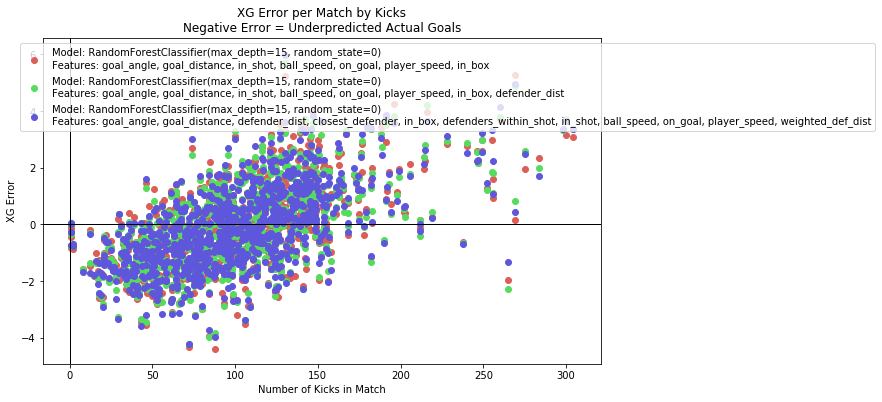

In [62]:
plot = blank_plot()
for model_id, color in zip(model_ids, pal):
    plot = plot_errors_by_kicks(models[model_id], d_test, plot, {"color": color})
plot[0]

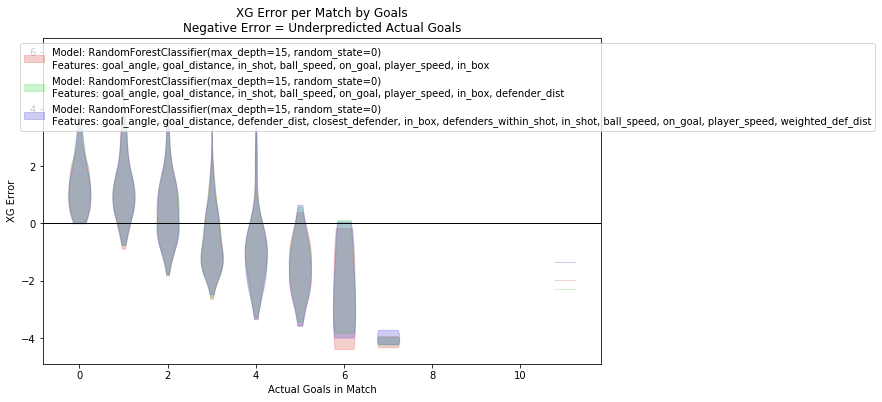

In [63]:
plot = blank_plot()
for model_id, color in zip(model_ids, pal):
    plot = plot_errors_by_goals(models[model_id], d_test, plot, {"color": color})
plot[0]

Feature ranking:
1. feature goal_distance (0.269607)
2. feature ball_speed (0.185643)
3. feature goal_angle (0.127698)
4. feature player_speed (0.105954)
5. feature weighted_def_dist (0.086346)
6. feature defender_dist (0.085705)
7. feature on_goal (0.057054)
8. feature defenders_within_shot (0.040122)
9. feature in_box (0.020078)
10. feature closest_defender (0.014440)
11. feature in_shot (0.007353)


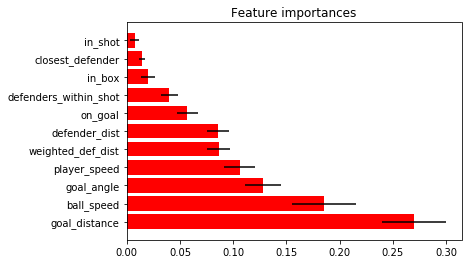

In [78]:
import matplotlib.pyplot as plt
features = models[4]['features']
X_train = d_train[features]
y_train = d_train["ag"]
clf = models[4]['clf']
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
        color="r", xerr=std[indices], align="center")

plt.yticks(range(X_train.shape[1]), [features[i] for i in indices])
plt.ylim([-1, X_train.shape[1]])
plt.show()

Feature ranking:
1. feature goal_distance (0.290480)
2. feature ball_speed (0.194050)
3. feature goal_angle (0.141251)
4. feature player_speed (0.123115)
5. feature defender_dist (0.104850)
6. feature on_goal (0.055333)
7. feature defenders_within_shot (0.041645)
8. feature in_box (0.022802)
9. feature closest_defender (0.019408)
10. feature in_shot (0.007065)


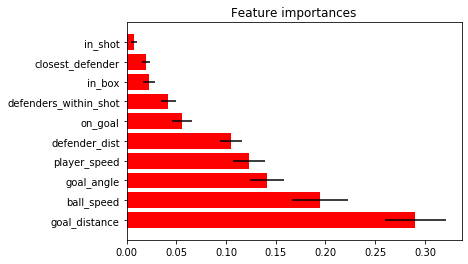

In [88]:
import matplotlib.pyplot as plt
features = models[1]['features']
X_train = d_train[features]
y_train = d_train["ag"]
clf = models[1]['clf']
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
        color="r", xerr=std[indices], align="center")

plt.yticks(range(X_train.shape[1]), [features[i] for i in indices])
plt.ylim([-1, X_train.shape[1]])
plt.show()